In [175]:
import sympy as sym
import sympy.physics.mechanics as me
from sympy.abc import t as time
import pandas as pd
import seaborn as sns

import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

import sys, os

sys.path.insert(1, os.path.join(sys.path[0], '../..'))
import custom_plot_objects as cpo

import moyra as ma
import moyra.elements as ele
import moyra.forces as ef

# import ModelFramework as mf
# import ModelFramework.Elements as ele
# import ModelFramework.ExternalForces as ef
import FwtModels.RectWing as rw
import FwtModels.RollRig as RollRig

from matplotlib.lines import Line2D

me.mechanics_printing()

In [176]:
half = sym.Rational(1,2)
fwt_panels = 10
main_panels = 20
p = RollRig.base_params(panels = (fwt_panels*2 + main_panels))

In [177]:
# Generate Referecne Frame
wing_frame = ma.HomogenousTransform().R_x(sym.pi+p.q[0])
rhs_fwt_frame = wing_frame.Translate(0,p.s_w*half,0).R_x(-p.q[1])  # RHS Fwt Frame
lhs_fwt_frame = wing_frame.Translate(0,-p.s_w*half,0).R_x(p.q[2])  # LHS Fwt Frame

#Generate Mass Matrices
M_w = ele.MassMatrix(p.m_w)
I_w = ele.MassMatrix(0,I_xx = p.I_xxw)
fwt_w = ele.MassMatrix(p.m_f,I_xx = p.I_xxf)

# Generate Rigid Elements
Wing_point_mass = ele.RigidElement(wing_frame.Translate(0,p.y_w,p.z_w),M_w,gravityPotential=True)
wing_inertia = ele.RigidElement(wing_frame,I_w)
rhs_fwt_mass = ele.RigidElement(rhs_fwt_frame.Translate(0,p.l_f,0),fwt_w,gravityPotential=True)
lhs_fwt_mass = ele.RigidElement(lhs_fwt_frame.Translate(0,-p.l_f,0),fwt_w,gravityPotential=True)

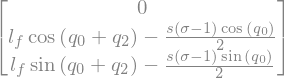

In [178]:
sym.simplify(lhs_fwt_frame.Translate(0,-p.l_f,0).Transform_point((0,0,0)))

In [179]:
# Main Wing Aero Forces 
wing_AeroForces = ef.AeroForce.PerUnitSpan(p,wing_frame.Translate(0,p.y_i,0),p.a_0,
                               alphadot = 0,
                               M_thetadot = 0,
                               e = 0,
                               w_g = 0,
                               rootAlpha = 0,
                               alpha_zero = 0,
                               stall_angle = 0,
                               c = p.c,
                                V = p.V,
                               c_d_max = 0,
                               linear = True,
                                z_inverted=True)

In [180]:
# split Main Wing into segments
forces = []
for i in range(main_panels):
    seg_width = p.s_w/main_panels
    yi = -p.s_w/2 + seg_width/2 + i*seg_width
    forces.append(wing_AeroForces.subs({p.y_i:yi,p.a_0:p.a[fwt_panels+i]})*seg_width)
Q = sym.Matrix([0]*p.qs)
for f in forces:
    Q += f.Q()
wing_AeroForces = ef.ExternalForce(Q)

In [181]:
# Left FWT Aero Forces
lhs_fwt_AeroForces = ef.AeroForce.PerUnitSpan(p,lhs_fwt_frame.Translate(0,-p.y_f*sym.cos(p.Lambda),0),p.a_0,
                               alphadot = 0,
                               M_thetadot = 0,
                               e = 0,
                               w_g = 0,
                               rootAlpha = p.alpha_2,
                               alpha_zero = 0,
                               stall_angle = 0,
                               c = p.c,
                                              V = p.V,
                               c_d_max = 0,
                               linear = True,
                               z_inverted=True)#.integrate((p.y_f,0,p.s_f))

In [182]:
# Left FWT Aero Forces 
rhs_fwt_AeroForces = ef.AeroForce.PerUnitSpan(p,rhs_fwt_frame.Translate(0,p.y_f*sym.cos(p.Lambda),0),p.a_0,
                               alphadot = 0,
                               M_thetadot = 0,
                               e = 0,
                               w_g = 0,
                               rootAlpha = p.alpha_1,
                               alpha_zero = 0,
                               stall_angle = 0,
                               c = p.c,
                                              V = p.V,
                               c_d_max = 0,
                               linear = True,
                                z_inverted=True)#.integrate((p.y_f,0,p.s_f))

In [183]:
# split FTW's into segments
forces = []
for i in range(fwt_panels):
    seg_width = p.s_f/fwt_panels
    yi = seg_width/2 + i*seg_width
    forces.append(lhs_fwt_AeroForces.subs({p.y_f:yi,p.a_0:p.a[fwt_panels-(i+1)]})*seg_width)
    forces.append(rhs_fwt_AeroForces.subs({p.y_f:yi,p.a_0:p.a[fwt_panels+main_panels+i]})*seg_width)
Q = sym.Matrix([0]*p.qs)
for f in forces:
    Q += f.Q()
fwt_AeroForces = ef.ExternalForce(Q)



In [184]:
Forcing = ef.CustomForce(None) 

CompositeForce = ef.CompositeForce([fwt_AeroForces,wing_AeroForces,Forcing])
# create instance of the model
sm = ma.SymbolicModel.FromElementsAndForces(p,[Wing_point_mass,wing_inertia,rhs_fwt_mass,lhs_fwt_mass],ExtForces = CompositeForce)

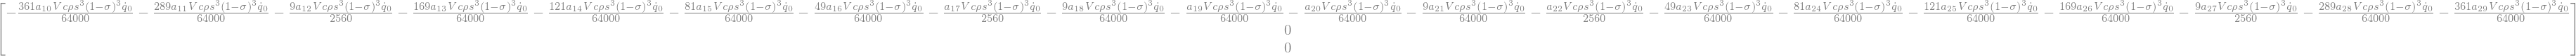

In [185]:
sm.to_file(p,'RollRigModel.py')
sm.ExtForces.Q()
wing_AeroForces.Q()

In [70]:
sm_mini = sm.subs({p.alpha_r:0,p.alpha_1:-sym.atan(sym.sin(p.Lambda)*sym.tan(p.q[1])),
             p.alpha_2:-sym.atan(sym.sin(p.Lambda)*sym.tan(p.q[2])),p.g:0})
sm_lin = sm_mini.linearise(p).subs({**{fp:0 for fp in p.fp},**{a:p.a[0] for a in p.a}})
mats = sm_lin.extract_matrices(p)
(A,B,C,D,E) = tuple([sym.simplify(a) for a in mats])

In [75]:
sm_lin.to_file(p,'RollRigModel_lin.py')

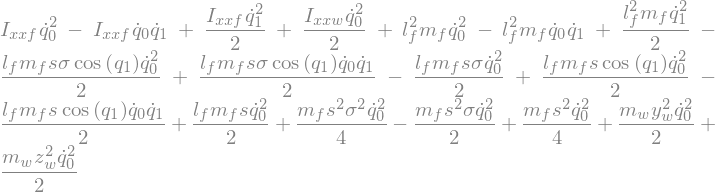

In [78]:
sym.simplify(sm.T.subs({p.q[2]:0}))

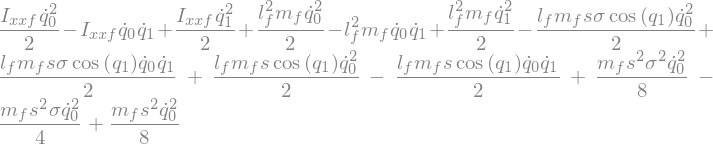

In [79]:
rhs_fwt_mass.calc_ke(p)

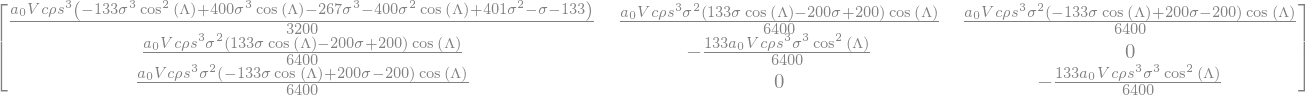

In [73]:
D

In [80]:
import sympy as sym
import sympy.physics.mechanics as me

In [107]:
(theta, phi) = me.dynamicsymbols('theta phi')
(thetad, phid) = me.dynamicsymbols('theta phi',1)
(m,m_t,y_1,y_2,S,S_w) = sym.symbols('m m_t y_1 y_2 S S_w')

In [168]:
m_1_frame = ma.HomogenousTransform().R_x(phi).Translate(0,y_1,0)
m_2_frame = ma.HomogenousTransform().R_x(phi).Translate(0,S_w,0).R_x(-theta).Translate(0,y_2,0)
t=me.dynamicsymbols._t

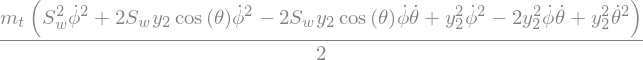

In [169]:
V= m_2_frame.Transform_point([0,0,0]).diff(t)
v = V.T*V
ke = sym.Rational(1/2)*m_t*sym.simplify(v[0])
ke

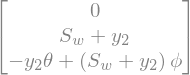

In [170]:
X = m_2_frame.Transform_point([0,0,0])
X = sym.simplify(ma.linearise_matrix(X,[phi,theta],[0,0]))
X

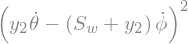

In [171]:
V = X.diff(t).T*X.diff(t)
V = sym.simplify(V[0])
V

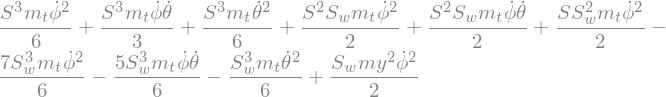

In [165]:
T = sym.integrate(sym.Rational(1,2)*m*(phid*y)**2,(y_1,0,S_w))+sym.integrate(sym.Rational(1,2)*m_t*V,(y_2,S_w,S))
T = sym.simplify(T)
T

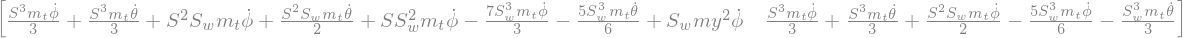

In [166]:
sym.Matrix([T]).jacobian(sym.Matrix([phid,thetad])).

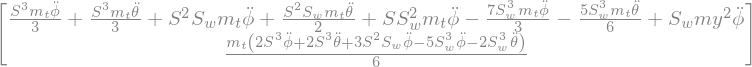

In [173]:
eom = sym.simplify(sym.Matrix([T]).jacobian(sym.Matrix([phid,thetad])).diff(me.dynamicsymbols._t)).T
eom
# sym.simplify(ma.linearise_matrix(eom,[phi,phid,theta,thetad],[0,0,0,0])).jacobian(sym.Matrix([phid,thetad]).diff(t))

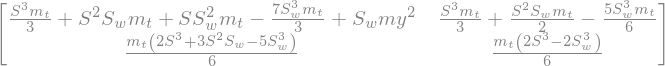

In [174]:
eom.jacobian(sym.Matrix([phid,thetad]).diff(t))

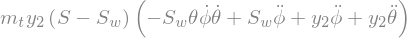

In [127]:
sym.simplify(T.diff(thetad).diff(me.dynamicsymbols._t).subs({sym.sin(theta):theta,sym.cos(theta):1}))

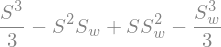

In [106]:
sym.simplify(K.diff(thetad.diff(me.dynamicsymbols._t)))